Post process 3D bbx tracking data produced in April 2021
Goals
1. rectify 3D bbox measurements into comprehensible trajecotry data for enhancing training
2. manual validate the rectified measurements with the videos

Tasks
1. compute homography matrix (done)
2. transform bottom 4 poitns into real-world coords (done)
3. work on the road plane (done, but dimensions seem incorrect)
4. use optimization to rectify measurements (see 3)
5. add motion (velocity. acceleration) constraints in optimization (done)
6. optimization switch direction south/north bound
6. Apply Joint Probabilistic Data Association algorithm (JPDA)
    https://stonesoup.readthedocs.io/en/latest/auto_tutorials/08_JPDATutorial.html
    a. one object has 4 measurements

In [1]:
from utils import *
import importlib
import utils
importlib.reload(utils)
import os.path
from os import path
import pandas as pd
import utils_optimization as opt
importlib.reload(opt)
import time
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp,least_squares
import numpy.linalg as LA


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data_path = pathlib.Path().absolute().joinpath('../2D-3D May 2021')
file_name = data_path.joinpath('record_p2c1_00001_track_outputs_corrected_3D.csv')
df = utils.read_data(file_name,0)
# df = df.rename(columns={'bbrx': 'bblx', 'bblx': 'bbrx', 'fblx': 'fbrx', 'fbrx': 'fblx',
#                        'bbry': 'bbly', 'bbly': 'bbry', 'fbly': 'fbry', 'fbry': 'fbly'})
# df['Timestamp'] = df['Frame #']/30
path_vpts = data_path.joinpath('camera_calibration_points_I24_validation_system.csv')
df = utils.calc_rr_coords(df, 'P2C1', path_vpts) # P1C4 good
A = [36.004654, -86.609976] # south west side, so that x, y coords obey counterclockwise
B = [36.002495, -86.607566]
df = utils.calc_xy(df,A,B)
print(len(df['ID'].unique()))
df = utils.get_x_direction(df)
df = utils.naive_filter_3D(df)
df = df[df['direction']=='+']
print(len(df['ID'].unique()))
df.head()

C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:50: RuntimeWarning: invalid value encountered in sin
  a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:50: RuntimeWarning: invalid value encountered in cos
  a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2


139


C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g[col_name]=Y[:,i]
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:279: RuntimeWarning: invalid value encountered in greater
  outliers = np.logical_or(w1>5, w2>5)
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:286: RuntimeWarning: invalid value encountered in greater
  outliers = abs(l1 - m1) > 2 * s1
C:\Users\wangy79\Documents\I24_trajectory\I24-trajectory-generation\utils.py:284: RuntimeWarning: Mean of empty slice
  m1 = np.nanmean(l1)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.

73


Frame #     Timestamp     ID Object class  BBox xmin  BBox ymin  \
7         0  1.758018e+09  22261        sedan    1494.00     560.00   
15        1           NaN  22261        sedan    1502.75     571.25   
23        2           NaN  22261        sedan    1511.50     582.50   
31        3           NaN  22261        sedan    1520.25     593.75   
38        4           NaN  22261        sedan    1529.00     605.00   

    BBox xmax  BBox ymax     vel_x      vel_y  ...     bbllon      fbr_y  \
7     1574.00     636.00  3.859742  15.289554  ... -86.608601        NaN   
15    1583.75     648.25  3.859742  15.289554  ... -86.608593        NaN   
23    1593.50     660.50  3.859742  15.289554  ... -86.608585        NaN   
31    1603.25     672.75  3.859742  15.289554  ... -86.608575        NaN   
38    1613.00     685.00  3.859742  15.289554  ... -86.608567  16.756352   

        fbl_y      bbr_y     bbl_y      fbr_x       fbl_x       bbr_x  \
7         NaN        NaN       NaN        NaN         NaN         NaN   
15        NaN        NaN       NaN        NaN         NaN         NaN   
23        NaN        NaN       NaN        NaN         NaN         NaN   
31        NaN        NaN       NaN        NaN         NaN         NaN   
38  18.915901  16.742403  18.91994  173.18855  173.946528  169.719018   

         bbl_x  direction  
7          NaN          +  
15         NaN          +  
23         NaN          +  
31         NaN          +  
38  170.529296          +  

[5 rows x 46 columns]

73  unique cars
ID: 22261


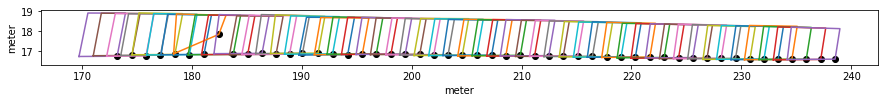

ID: 24261


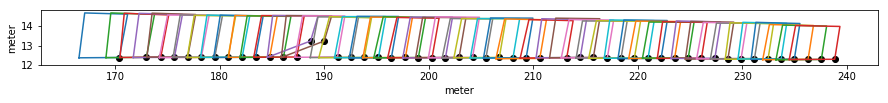

ID: 30261


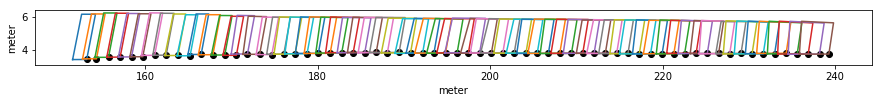

ID: 37261


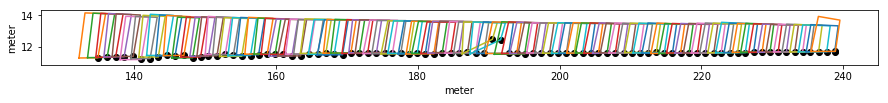

ID: 39261


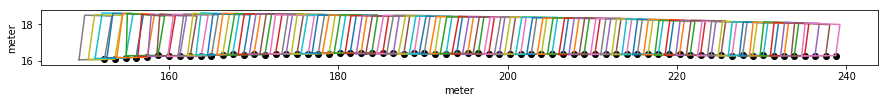

ID: 49261


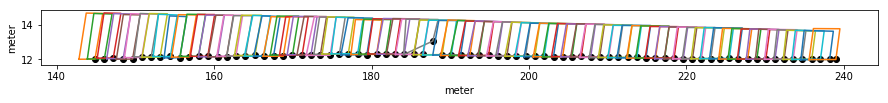

ID: 56261


KeyboardInterrupt: 

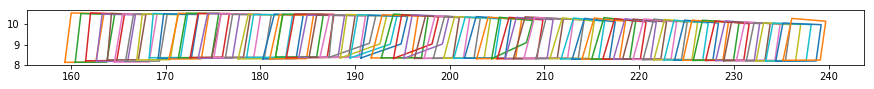

In [3]:
# plot original

# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,' unique cars')

for i in range(nO):
    ID = groupList[i]
#     ID = 100261
    Y1 = groups.get_group(ID)

    # get bottom 4 points coordinates
    Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
    Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

    # plot 
    print('ID:',ID)
    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))

    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black') # fbr
#     plt.scatter(D[:,0],D[:,1],color='blue') # bbr
#     plt.scatter(D[:,4],D[:,5],color='red') # fbl
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 


73 unique cars
ID: 22261 Valid/total timestamps: 119 / 51 score: 5.128486194262983 runtime: 4.826297998428345 
 width: 1.8151347217980134 length: 4.254427944521483


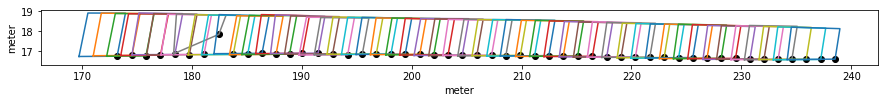

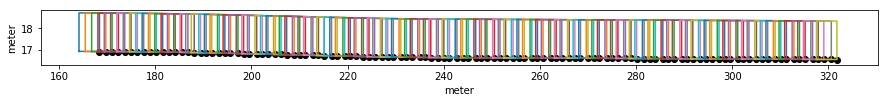

ID: 24261 Valid/total timestamps: 142 / 52 score: 5.510357715483703 runtime: 5.441224813461304 
 width: 2.002983465236425 length: 4.233056146548617


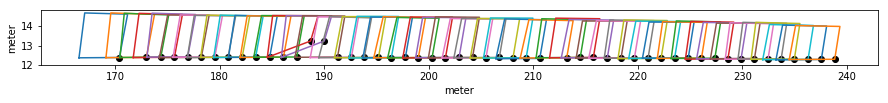

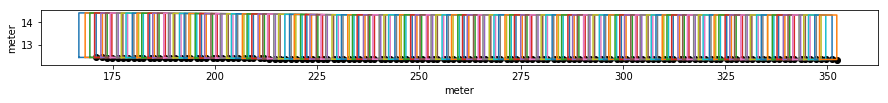

ID: 30261 Valid/total timestamps: 66 / 66 score: 9.436327430178977 runtime: 2.776200771331787 
 width: 2.1528856409710655 length: 2.930165585322706


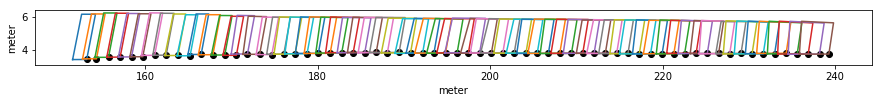

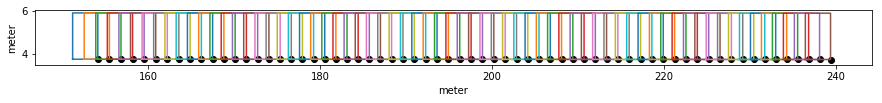

ID: 37261 Valid/total timestamps: 116 / 91 score: 9.7721669827547 runtime: 3.731642961502075 
 width: 2.092028102864726 length: 3.8198179155257383


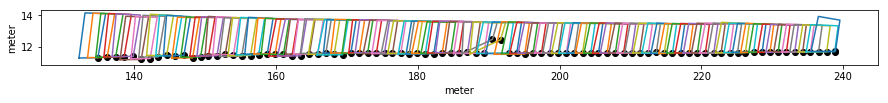

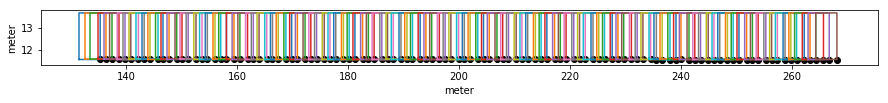

ID: 39261 Valid/total timestamps: 113 / 70 score: 6.901909614394767 runtime: 3.8257851600646973 
 width: 2.198216920270173 length: 4.2030793232212735


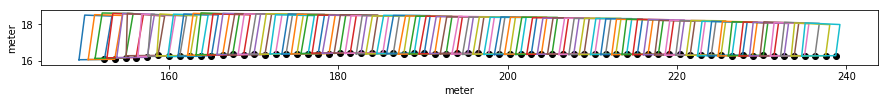

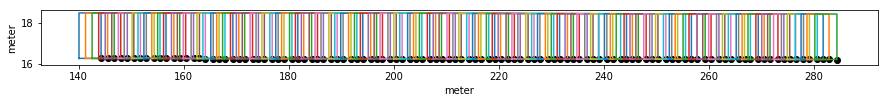

ID: 49261 Valid/total timestamps: 143 / 81 score: 9.297013842195684 runtime: 4.369605541229248 
 width: 2.0348199992995437 length: 3.2187341128937783


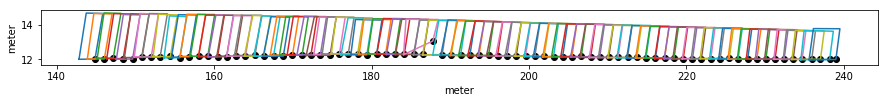

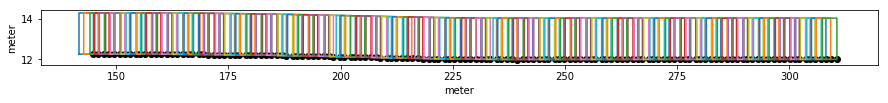

ID: 56261 Valid/total timestamps: 100 / 71 score: 8.581479330540175 runtime: 3.3811147212982178 
 width: 1.9953516257133306 length: 3.8405412453468553


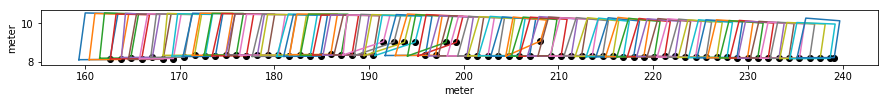

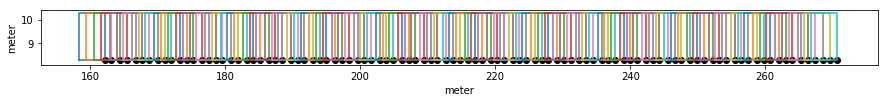

ID: 63261 Valid/total timestamps: 142 / 91 score: 11.510516989663003 runtime: 4.087964296340942 
 width: 2.2306830412351513 length: 3.20855089766862


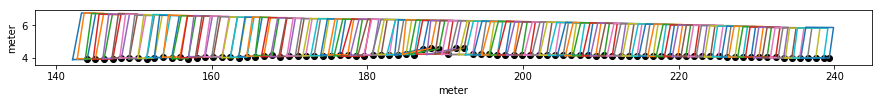

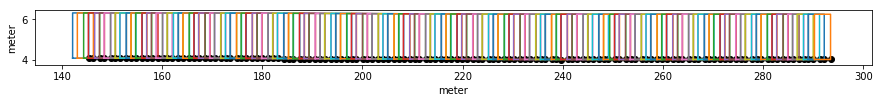

ID: 69261 Valid/total timestamps: 130 / 81 score: 9.717595923050446 runtime: 3.7827253341674805 
 width: 2.233576885729105 length: 4.4810962028462615


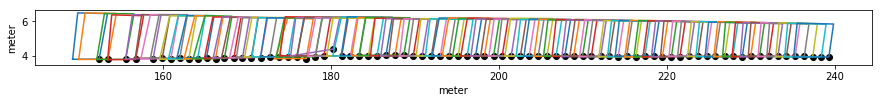

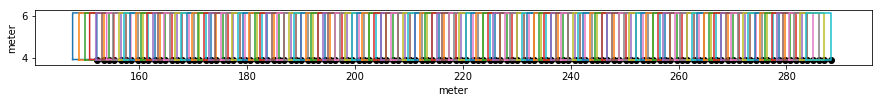

ID: 70261 Valid/total timestamps: 135 / 77 score: 9.270929999722824 runtime: 4.985536575317383 
 width: 1.9925727857145161 length: 3.596634390656513


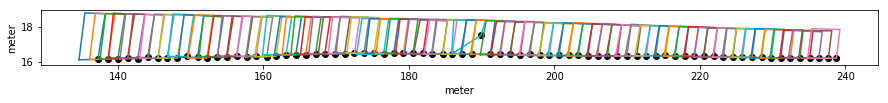

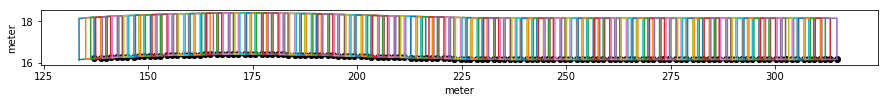

ID: 73261 Valid/total timestamps: 153 / 82 score: 7.847711756911027 runtime: 4.47977352142334 
 width: 2.2808118753538853 length: 4.503234377746055


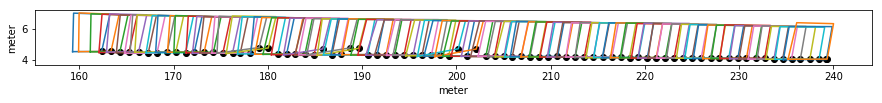

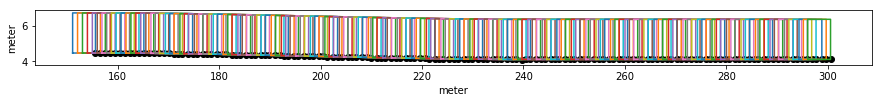

ID: 76261 Valid/total timestamps: 170 / 149 score: 52.35756479900204 runtime: 4.901411533355713 
 width: 3.10811343534894 length: 18.100963397342408


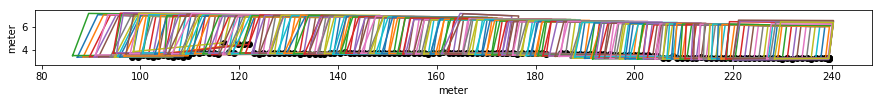

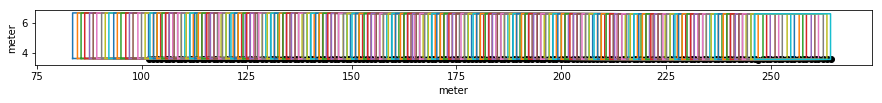

ID: 78261 Valid/total timestamps: 157 / 96 score: 12.24803917993369 runtime: 4.616979122161865 
 width: 2.12067316857351 length: 3.1880147550932154


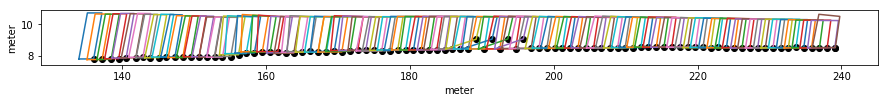

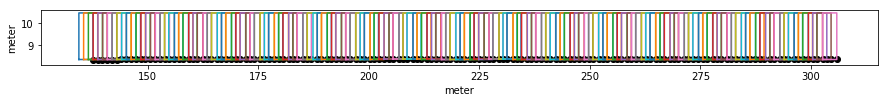

ID: 80261 Valid/total timestamps: 148 / 81 score: 11.884235307808463 runtime: 4.4627461433410645 
 width: 1.9489488415546747 length: 3.0817190594861223


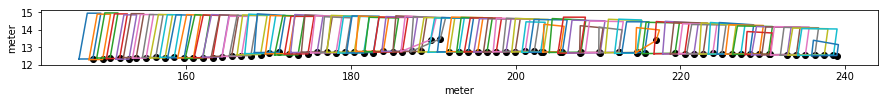

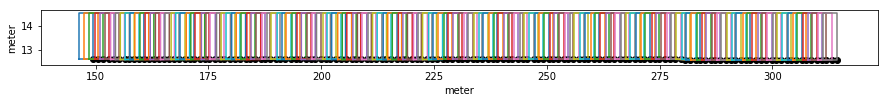

ID: 83261 Valid/total timestamps: 84 / 81 score: 12.088299709008988 runtime: 2.9775002002716064 
 width: 2.0529443610092826 length: 3.8039146629294485


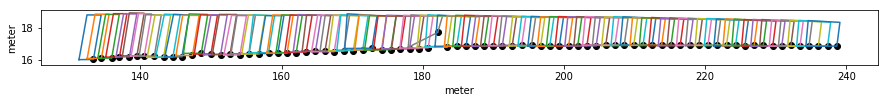

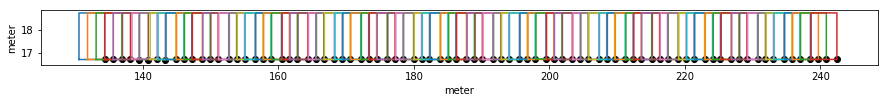

ID: 86261 Valid/total timestamps: 192 / 171 score: 48.907212030487486 runtime: 5.408179998397827 
 width: 3.76776562643002 length: 19.37486093133516


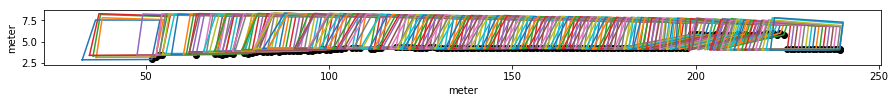

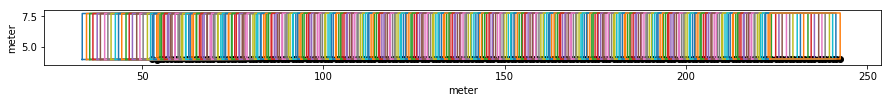

ID: 87261 Valid/total timestamps: 86 / 17 score: 35.4495821915127 runtime: 3.034592628479004 
 width: 1.9443944333219823 length: 6.001385703034245


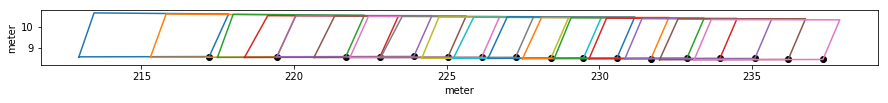

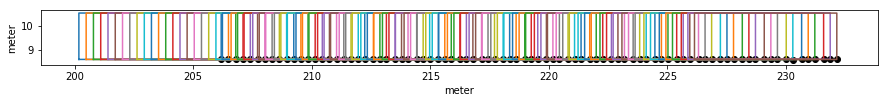

ID: 89261 Valid/total timestamps: 160 / 157 score: 21.139382257993102 runtime: 4.746173620223999 
 width: 3.0485685633904054 length: 12.026030432271082


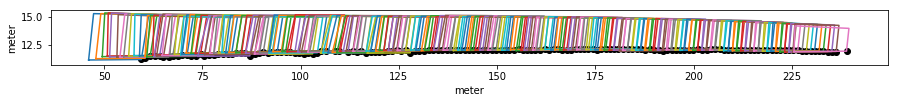

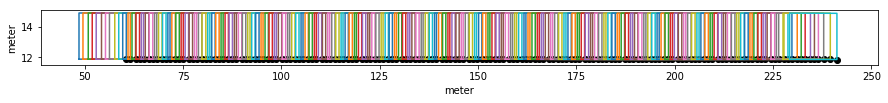

ID: 93261 Valid/total timestamps: 162 / 93 score: 17.167130148074747 runtime: 4.795262575149536 
 width: 2.5126394899505433 length: 4.6691388193679515


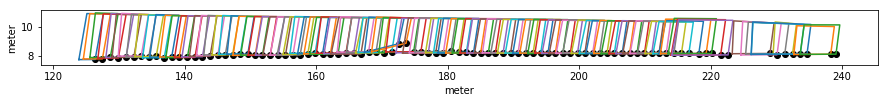

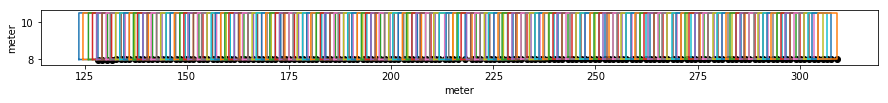

ID: 96261 Valid/total timestamps: 72 / 66 score: 23.01561496247872 runtime: 2.6750519275665283 
 width: 2.123071580369807 length: 2.5077141512973897


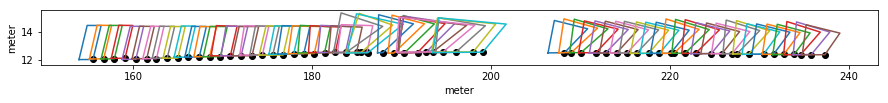

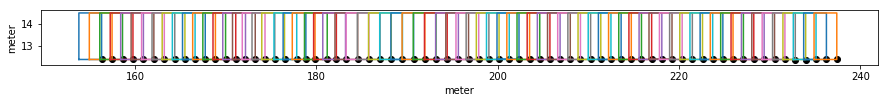

ID: 98261 Valid/total timestamps: 127 / 70 score: 10.327072902526698 runtime: 3.8728551864624023 
 width: 2.1487383826884905 length: 3.939968624787047


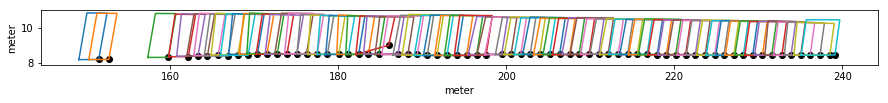

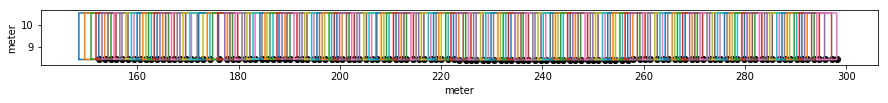

ID: 100261 Valid/total timestamps: 79 / 66 score: 16.496862896683794 runtime: 2.7882158756256104 
 width: 2.290203743261605 length: 4.282759497003752


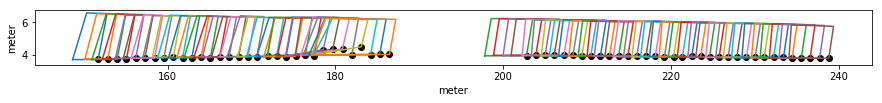

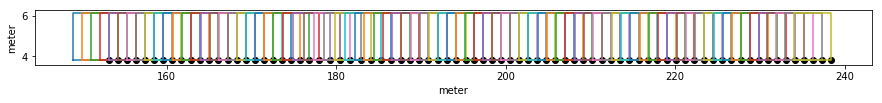

ID: 102261 Valid/total timestamps: 138 / 62 score: 8.7724880056831 runtime: 6.04313588142395 
 width: 2.0475140351711048 length: 4.879629304908307


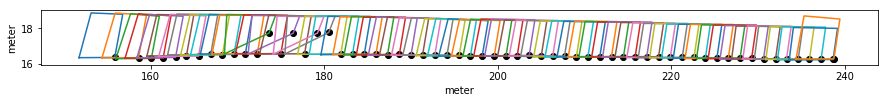

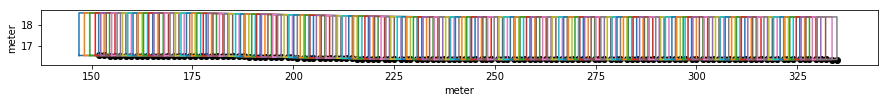

ID: 105261 Valid/total timestamps: 119 / 70 score: 7.733808631368267 runtime: 4.931468725204468 
 width: 1.9642965394298244 length: 3.9155722009780307


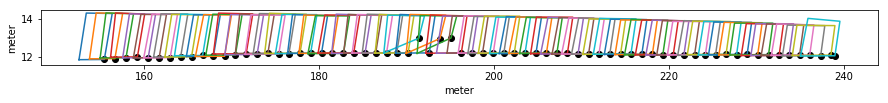

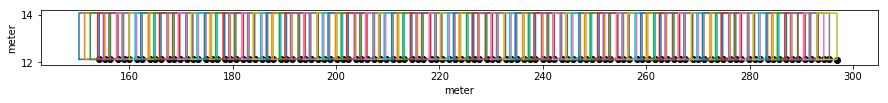

ID: 109261 Valid/total timestamps: 134 / 91 score: 17.948859412970563 runtime: 4.204354524612427 
 width: 2.3033159027167964 length: 3.4434533858344785


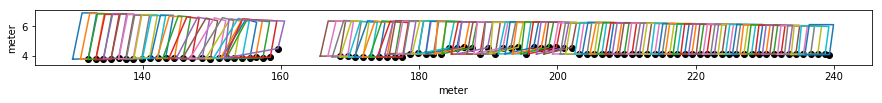

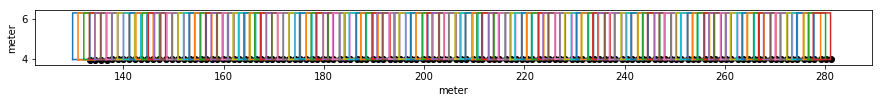

ID: 118261 Valid/total timestamps: 152 / 107 score: 16.422851681020255 runtime: 4.862349987030029 
 width: 2.419423720446117 length: 4.180541829314436


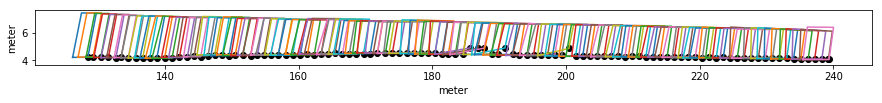

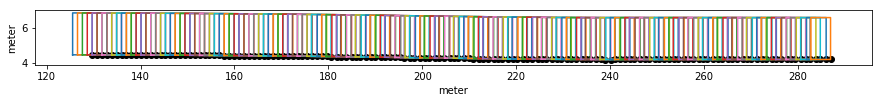

ID: 120261 Valid/total timestamps: 119 / 59 score: 6.125586738565317 runtime: 3.6765553951263428 
 width: 1.981123361262352 length: 3.6476851308974676


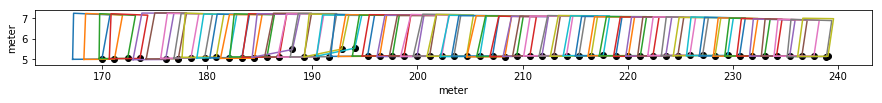

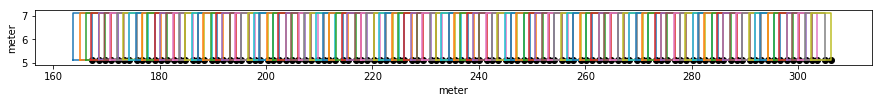

ID: 123261 Valid/total timestamps: 81 / 47 score: 6.391679439365868 runtime: 3.134737730026245 
 width: 2.064948152400145 length: 4.076185154737608


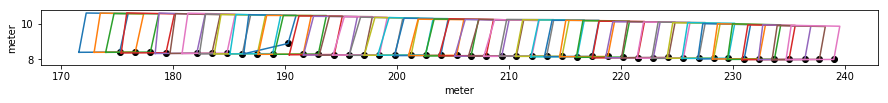

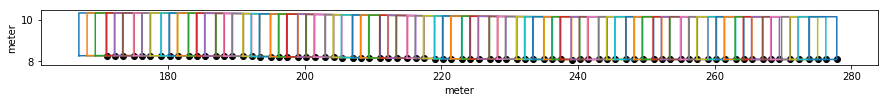

ID: 124261 Valid/total timestamps: 122 / 70 score: 6.269876970616928 runtime: 3.871852159500122 
 width: 1.8604687743758412 length: 3.996589926968349


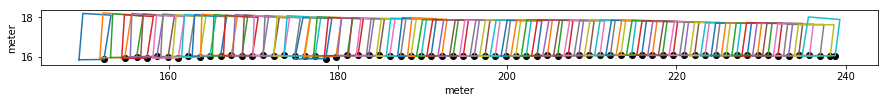

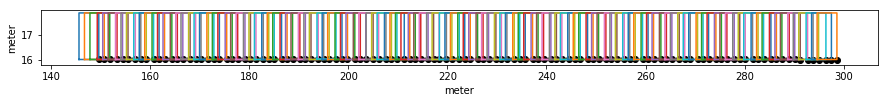

ID: 129261 Valid/total timestamps: 106 / 69 score: 8.80968722283796 runtime: 3.3330421447753906 
 width: 2.003850430211225 length: 3.2024450396609745


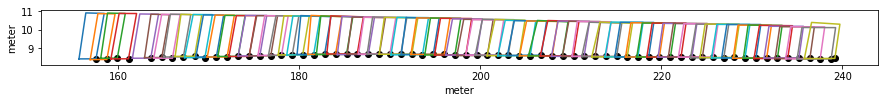

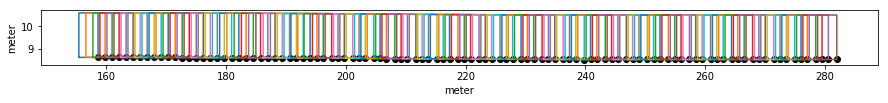

ID: 130261 Valid/total timestamps: 131 / 82 score: 9.192701449195516 runtime: 4.000046253204346 
 width: 2.2371830737877603 length: 4.091019684555194


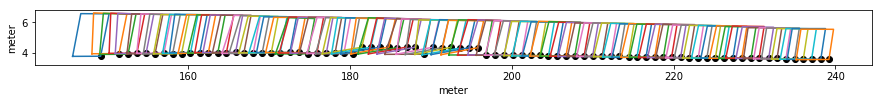

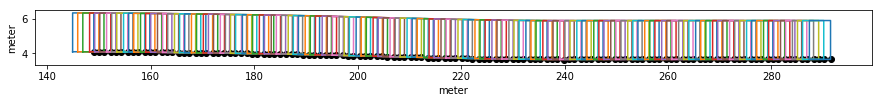

ID: 136261 Valid/total timestamps: 131 / 86 score: 11.137273051201353 runtime: 4.247419834136963 
 width: 2.0709345839853457 length: 4.152893201296327


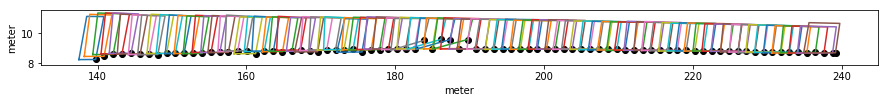

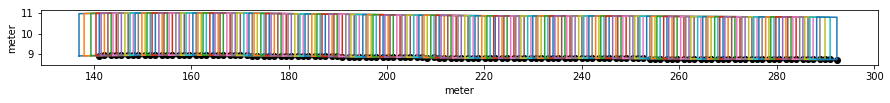

ID: 138261 Valid/total timestamps: 127 / 86 score: 11.009516903164176 runtime: 3.8227779865264893 
 width: 2.2224374728219556 length: 3.302940899875982


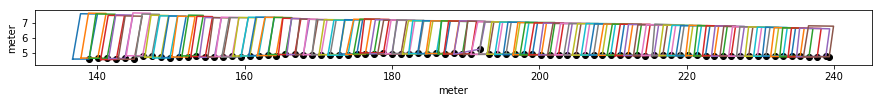

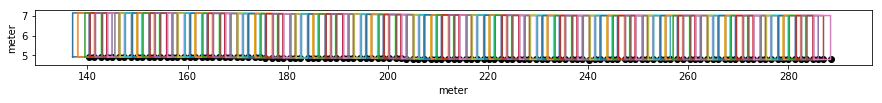

ID: 139261 Valid/total timestamps: 81 / 70 score: 87.75463477779749 runtime: 0.7280986309051514 
 width: 2.0 length: 4.0


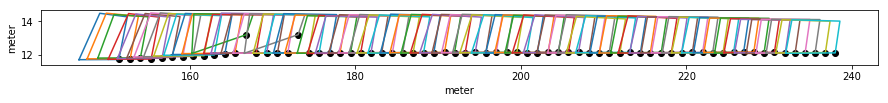

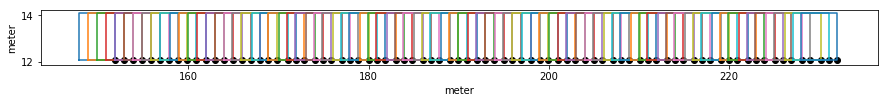

ID: 143261 Valid/total timestamps: 156 / 88 score: 8.936918219742203 runtime: 4.5078136920928955 
 width: 2.1929646468989654 length: 5.727526798546686


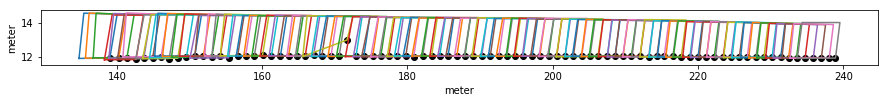

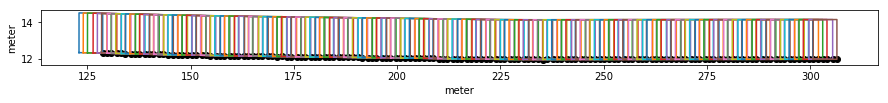

ID: 147261 Valid/total timestamps: 110 / 86 score: 8.919785698467688 runtime: 3.563384532928467 
 width: 2.167900557449934 length: 4.336934739514944


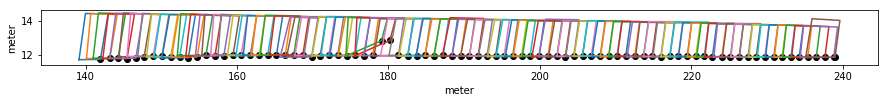

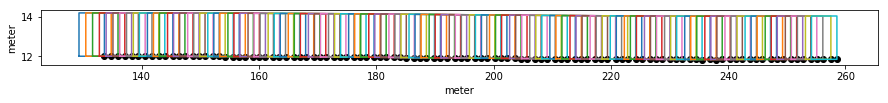

ID: 148261 Valid/total timestamps: 157 / 92 score: 14.180876055970966 runtime: 4.549891710281372 
 width: 2.122464526435514 length: 4.31632274593256


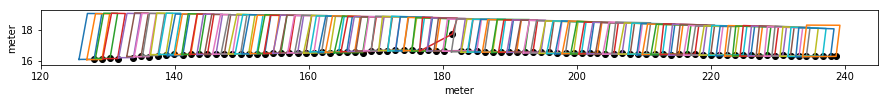

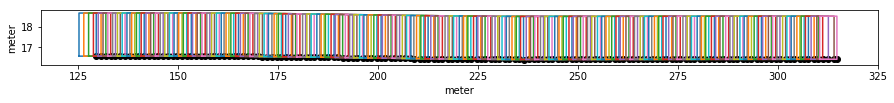

ID: 150261 Valid/total timestamps: 89 / 71 score: 7.765234710219961 runtime: 3.108699321746826 
 width: 1.994009703529789 length: 4.5627194996337455


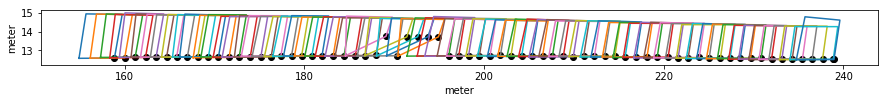

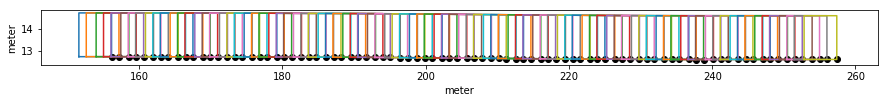

ID: 155261 Valid/total timestamps: 123 / 77 score: 11.473681299917999 runtime: 4.569927930831909 
 width: 2.1363544539683135 length: 3.874011451493642


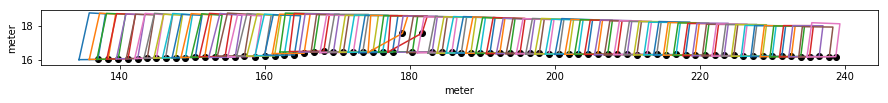

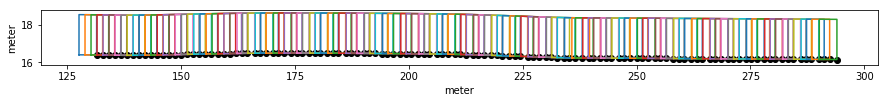

ID: 156261 Valid/total timestamps: 182 / 110 score: 37.58725882868691 runtime: 5.1828343868255615 
 width: 3.0942474471627777 length: 23.82603051503298


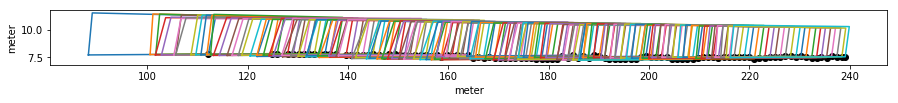

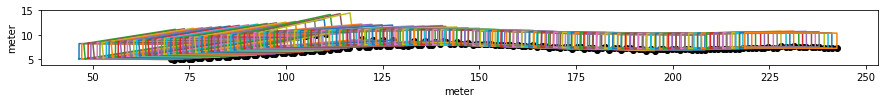

ID: 157261 Valid/total timestamps: 116 / 84 score: 12.103426107846579 runtime: 3.696589469909668 
 width: 2.2121221819374126 length: 4.484383420306469


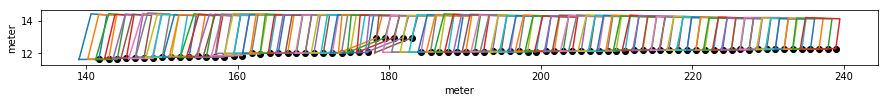

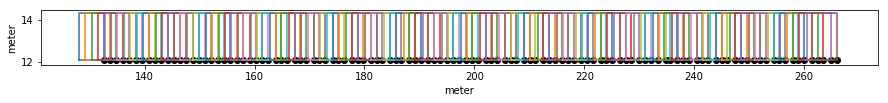

ID: 158261 Valid/total timestamps: 107 / 75 score: 12.213096085398577 runtime: 3.9059033393859863 
 width: 2.10067943860492 length: 4.125205439002425


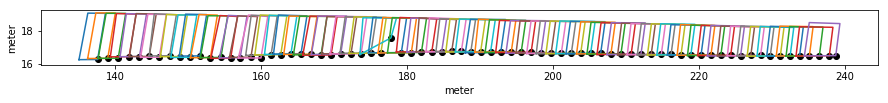

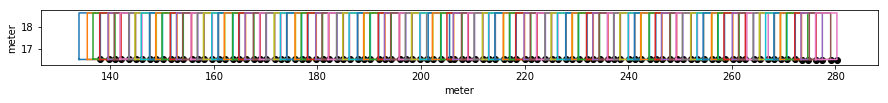

ID: 159261 Valid/total timestamps: 146 / 73 score: 7.292544263558694 runtime: 5.09970760345459 
 width: 2.0617497269758163 length: 4.312013513240648


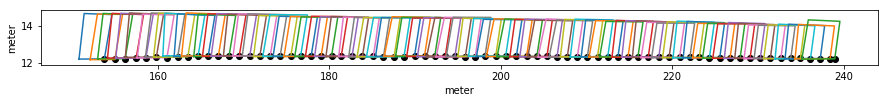

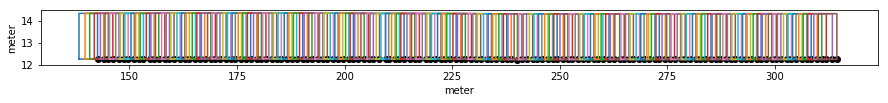

ID: 161261 Valid/total timestamps: 115 / 89 score: 64.78946452368145 runtime: 1.1407265663146973 
 width: 2.0 length: 4.0


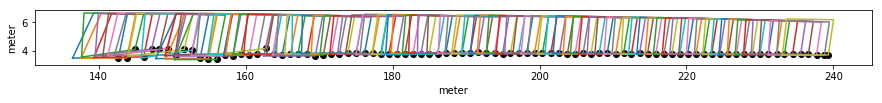

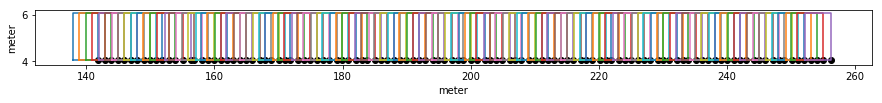

ID: 165261 Valid/total timestamps: 188 / 148 score: 26.53371063100534 runtime: 5.985050201416016 
 width: 3.2395872756426405 length: 22.41086830529265


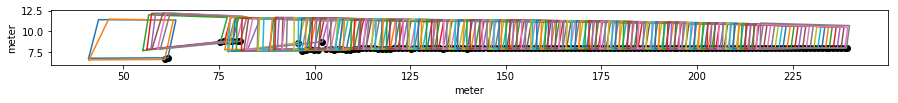

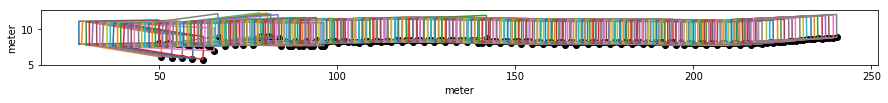

ID: 167261 Valid/total timestamps: 88 / 88 score: 13.373604566202049 runtime: 3.24590802192688 
 width: 2.0795641918161794 length: 3.31026688884027


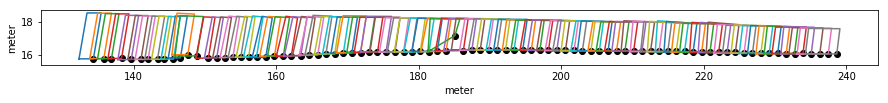

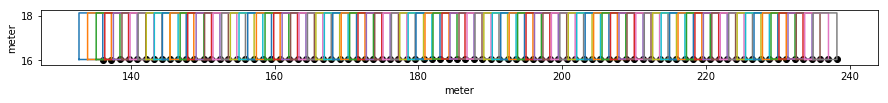

ID: 172261 Valid/total timestamps: 183 / 122 score: 14.50806039327913 runtime: 6.296522855758667 
 width: 2.450763079952094 length: 2.965356710437272


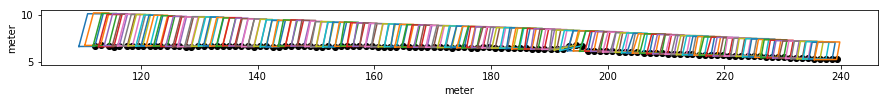

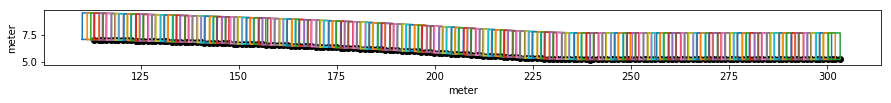

ID: 175261 Valid/total timestamps: 188 / 104 score: 17.26848452949518 runtime: 7.17084264755249 
 width: 2.3180566639809372 length: 3.0494086890695833


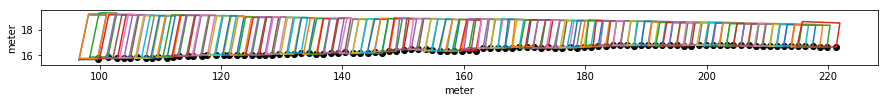

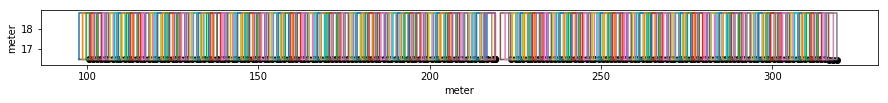

ID: 176261 Valid/total timestamps: 93 / 77 score: 13.860839351599344 runtime: 4.334557771682739 
 width: 2.3757852763809977 length: 5.087365925395225


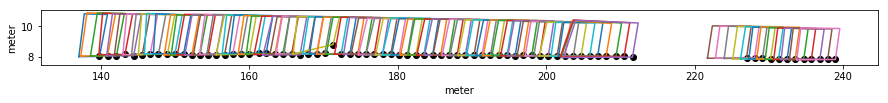

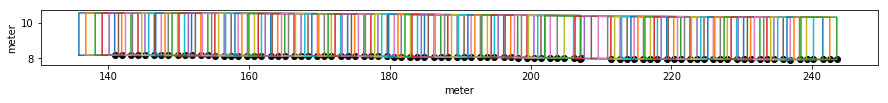

ID: 181261 Valid/total timestamps: 124 / 67 score: 12.082285607085401 runtime: 4.758195638656616 
 width: 2.209141154000495 length: 4.8037091844209865


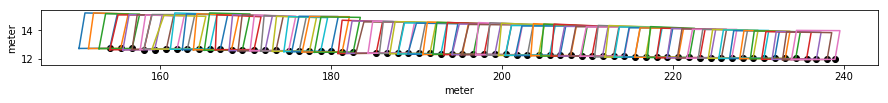

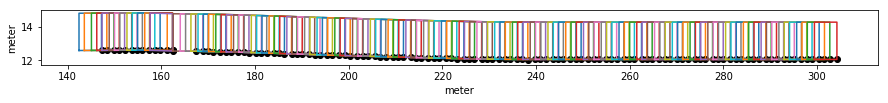

ID: 184261 Valid/total timestamps: 95 / 48 score: 5.689807270130277 runtime: 3.685570478439331 
 width: 1.988185975458141 length: 3.712026957376594


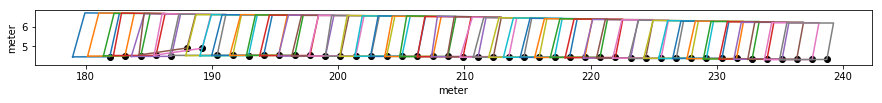

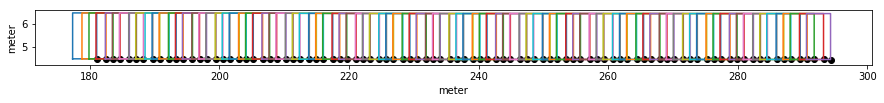

ID: 187261 Valid/total timestamps: 67 / 63 score: 6.160011951751665 runtime: 3.492281436920166 
 width: 2.3587997242302023 length: 7.158425196965273


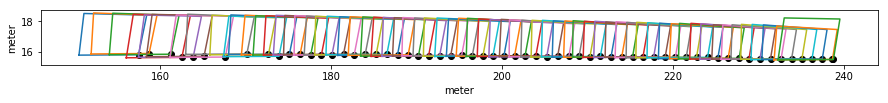

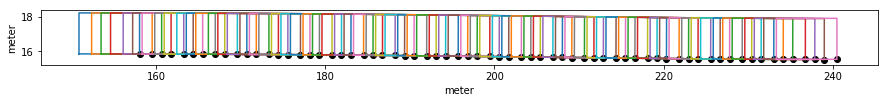

ID: 193261 Valid/total timestamps: 66 / 66 score: 10.063309673334768 runtime: 3.18182110786438 
 width: 1.9702955036514656 length: 3.2571337128834736


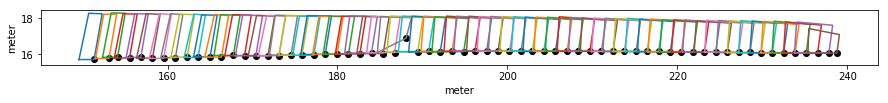

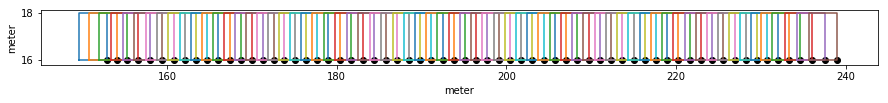

ID: 197221 Valid/total timestamps: 88 / 78 score: 9.60261436600828 runtime: 4.110214710235596 
 width: 2.200179040292173 length: 5.3130599917200305


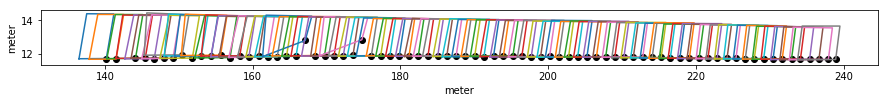

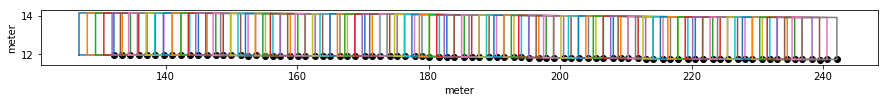

ID: 197261 Valid/total timestamps: 130 / 69 score: 6.950564918620702 runtime: 4.407662391662598 
 width: 2.0346396911798377 length: 4.3675498115173275


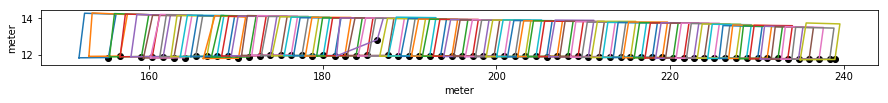

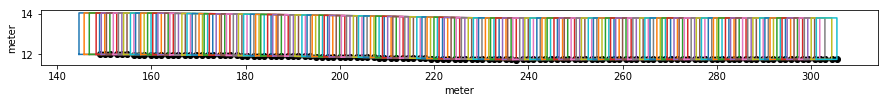

ID: 202261 Valid/total timestamps: 134 / 76 score: 10.02277474947323 runtime: 5.025599002838135 
 width: 2.0712264737570667 length: 3.873380042823053


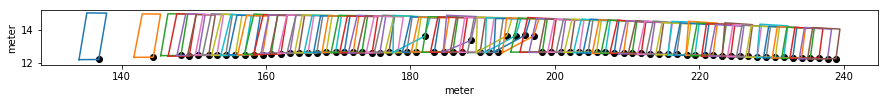

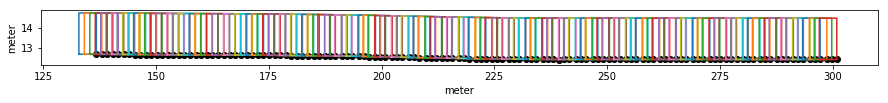

ID: 205261 Valid/total timestamps: 121 / 82 score: 9.270145442851597 runtime: 3.6945838928222656 
 width: 2.333948889862171 length: 5.4161505632217555


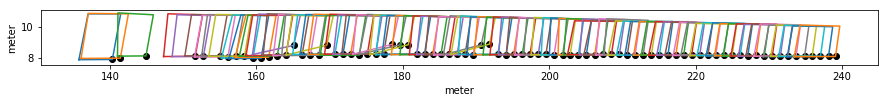

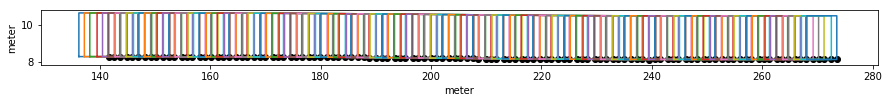

ID: 208261 Valid/total timestamps: 130 / 82 score: 10.775549508085842 runtime: 3.933945894241333 
 width: 1.885685309657416 length: 3.184144279547207


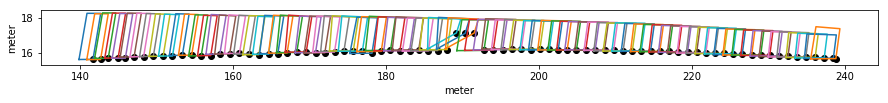

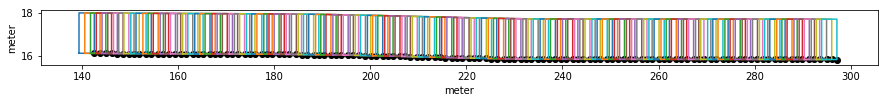

ID: 209261 Valid/total timestamps: 127 / 74 score: 8.208227229243194 runtime: 3.8878746032714844 
 width: 2.3255433221719723 length: 4.200134242867881


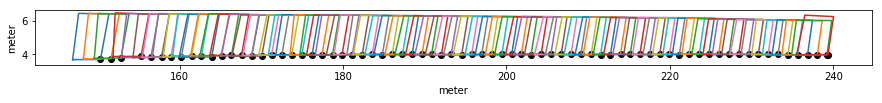

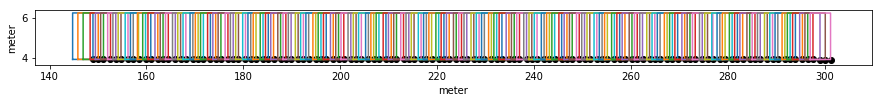

ID: 214261 Valid/total timestamps: 92 / 78 score: 16.909467238675948 runtime: 3.182809591293335 
 width: 2.0039498166876113 length: 3.361853263781211


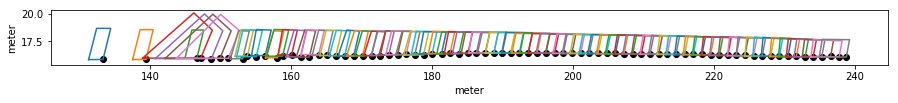

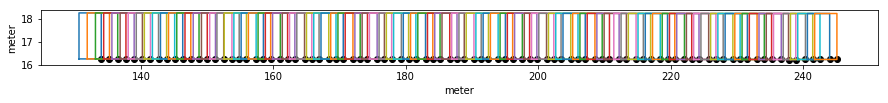

ID: 215261 Valid/total timestamps: 93 / 80 score: 9.950951241799029 runtime: 3.7727034091949463 
 width: 2.0588400893598613 length: 4.720926498472062


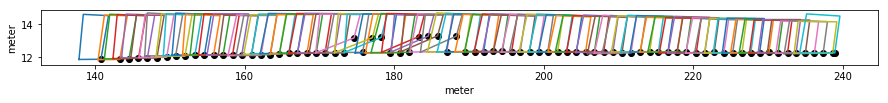

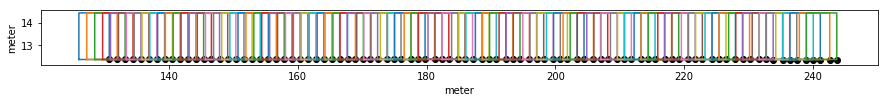

ID: 218261 Valid/total timestamps: 140 / 73 score: 8.940011792322538 runtime: 5.512333631515503 
 width: 1.916279889594094 length: 3.9000195624405922


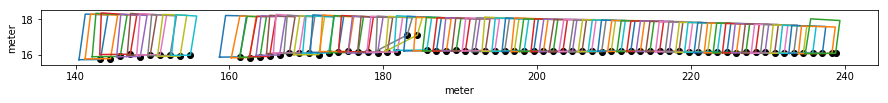

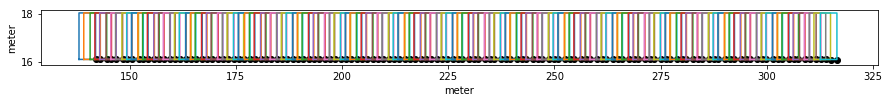

ID: 221261 Valid/total timestamps: 165 / 161 score: 52.59993062239629 runtime: 6.073182821273804 
 width: 3.4834797877773185 length: 23.863740098342742


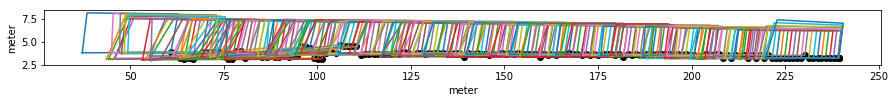

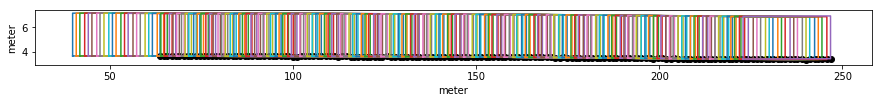

ID: 227261 Valid/total timestamps: 101 / 72 score: 7.743600213643221 runtime: 3.751671552658081 
 width: 2.0716097480802893 length: 3.7269865492687977


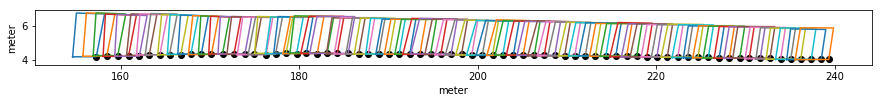

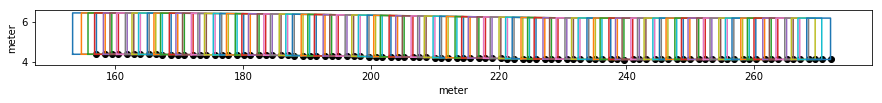

ID: 230261 Valid/total timestamps: 139 / 71 score: 6.852835670091889 runtime: 5.524354696273804 
 width: 2.0126312468333305 length: 4.4261590907583335


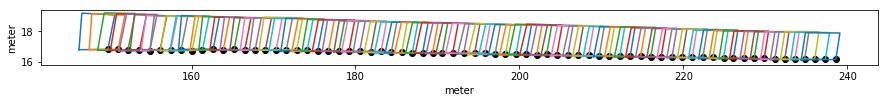

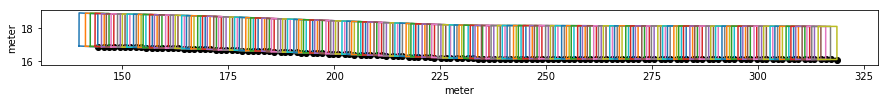

ID: 241261 Valid/total timestamps: 114 / 97 score: 9.607155680315646 runtime: 4.42069673538208 
 width: 2.1551450988562197 length: 3.462606930533525


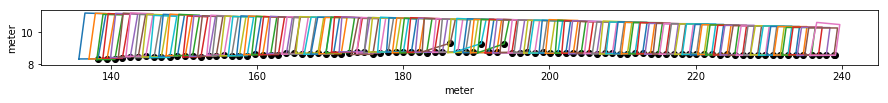

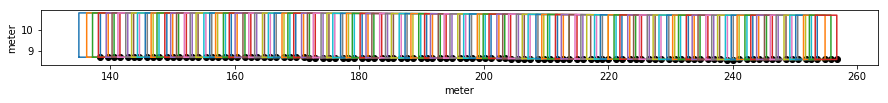

ID: 250261 Valid/total timestamps: 123 / 80 score: 23.20981986469554 runtime: 1.811739206314087 
 width: 2.0 length: 4.0


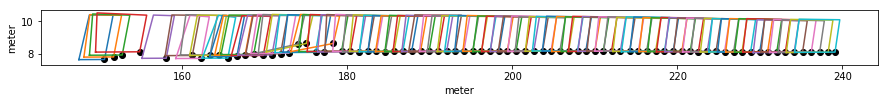

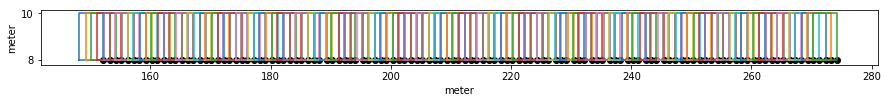

ID: 263221 Valid/total timestamps: 111 / 86 score: 17.896293866681425 runtime: 4.510816335678101 
 width: 3.6682428148489494 length: 22.827136706463584


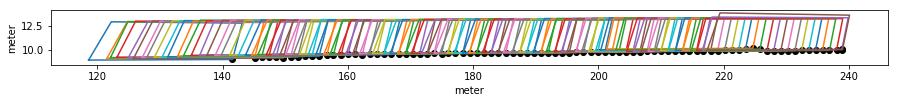

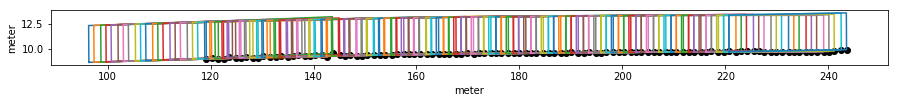

ID: 264221 Valid/total timestamps: 118 / 95 score: 55.79332894965689 runtime: 4.326539516448975 
 width: 3.542979545224835 length: 23.290161597189375


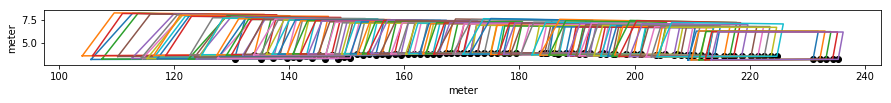

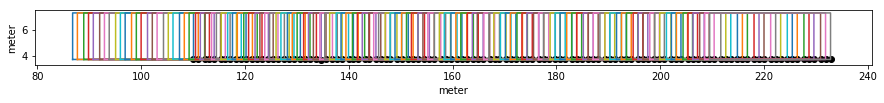

ID: 270211 Valid/total timestamps: 27 / 26 score: 12.690350969883346 runtime: 0.28142619132995605 
 width: 2.0 length: 4.0


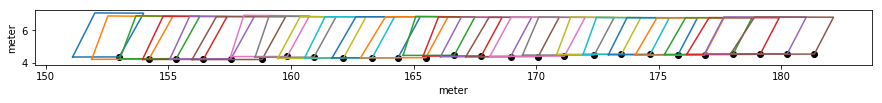

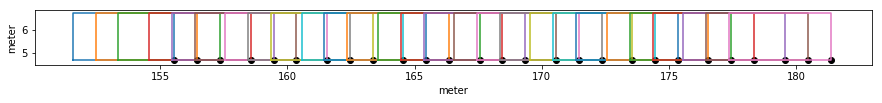

ID: 273211 Valid/total timestamps: 26 / 24 score: 7.289911208692619 runtime: 1.2098283767700195 
 width: 2.749165034711956 length: 2.6853971988080385


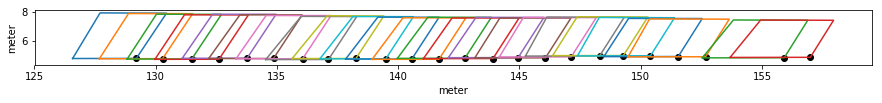

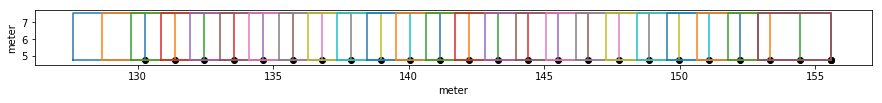

ID: 312261 Valid/total timestamps: 174 / 163 score: 48.43489372565498 runtime: 5.015581130981445 
 width: 3.373468314175582 length: 20.923939371647585


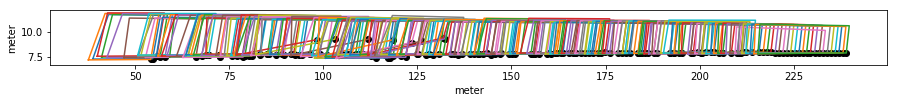

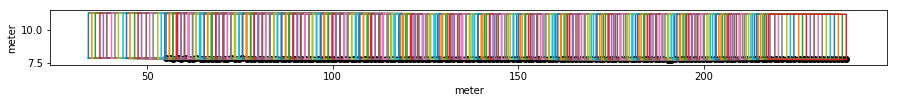

IndexError: index 0 is out of bounds for axis 0 with size 0

In [71]:
import utils_optimization as opt
importlib.reload(opt)
# group by objects

groups = df.groupby('ID')
groupList = list(groups.groups)
nO = len(groupList) # number of cars to test
print(nO,'unique cars')
# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # regularize acceleration 100
lam3 = 10 # theta
del score
score = np.zeros(nO) # record correction score

for i in range(nO):
    ID = groupList[i]
    Y1 = groups.get_group(ID)
    
    # impute missing timestamps
    timestamps = Y1['Timestamp'].values
    nans, x= utils.nan_helper(timestamps)
    timestamps[nans]= np.interp(x(nans), x(~nans), timestamps[~nans])
    dt = np.diff(timestamps)

    # get bottom 4 points coordinates
    Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
    Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])
    
    if len(Y1)<2:
        continue
    # Euler forward dynamics
    N = len(Y1) 
    notNan = ~np.isnan(np.sum(Y1,axis=-1))
    Y1 = Y1[notNan,:]
    v0 = 30
    a0 = np.zeros((N))
    theta0 = np.zeros((N))
    x0 = (Y1[0,0]+Y1[0,6])/2
    y0 = (Y1[0,1]+Y1[0,7])/2
    X0 = np.concatenate((a0.T, theta0.T, [v0,x0,y0,2,4]),axis=-1)

    bnds = [(-5,5) for i in range(0,N)]+\
        [(-np.pi/8,np.pi/8) for i in range(N)]+\
        [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

    # Constraints definition (only for COBYLA, SLSQP and trust-constr)
    start = time.time()
    res = minimize(opt.obj, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4), method = 'L-BFGS-B',
                    bounds=bnds, options={'disp': True,'maxiter':100000})#
    end = time.time()

    # extract results
    Yre, x,y,v,a,theta,w,l = opt.unpack(res,N,dt)
    score[i] = LA.norm(Y1-Yre[notNan,:],'fro')/np.count_nonzero(notNan)
    print('ID:',ID, 'Valid/total timestamps:',N, '/',np.count_nonzero(notNan),'score:',score[i],\
          'runtime:',end - start,'\n width:',w,'length:',l) 
    # plot 
    D = Y1
    fig, ax = plt.subplots(figsize=(15,1))

    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 

    D = Yre
    fig, ax = plt.subplots(figsize=(15,1))
    for i in range(len(D)):
        coord = D[i,:]
        coord = np.reshape(coord,(-1,2)).tolist()
        coord.append(coord[0]) #repeat the first point to create a 'closed loop'
        xs, ys = zip(*coord) #lon, lat as x, y
        plt.plot(xs,ys)
    plt.scatter(D[:,2],D[:,3],color='black')
    ax = plt.gca()
    plt.xlabel('meter')
    plt.ylabel('meter')
    ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
    plt.show() 

In [45]:
import utils_optimization as opt
importlib.reload(opt)

# optimization parameters
lam1 = 1 # modification of measurement
lam2 = 1 # acceleration
lam3 = 0 # jerk
lam4 = 10 # theta
lam5 = 1 # omega
ID = 86261 
Y1 = groups.get_group(ID)

timestamps = Y1['Timestamp'].values
nans, x= utils.nan_helper(timestamps)
timestamps[nans]= np.interp(x(nans), x(~nans), timestamps[~nans])

dt = np.diff(timestamps)

# get bottom 4 points coordinates
Y1gps = np.array(Y1[['bbrlat','bbrlon','fbrlat','fbrlon','fbllat','fbllon','bbllat','bbllon']])
Y1 = np.array(Y1[['bbr_x','bbr_y', 'fbr_x','fbr_y','fbl_x','fbl_y','bbl_x', 'bbl_y']])

# Euler forward dynamics
start = time.time()
N = len(Y1) 
notNan = ~np.isnan(np.sum(Y1,axis=-1))
Y1 = Y1[notNan,:]
a0 = np.zeros((N))
theta0 = np.zeros((N))
v0 = (Y1[-1,0]-Y1[0,0])/(timestamps[notNan][-1]-timestamps[notNan][0])
x0 = (Y1[0,0]+Y1[0,6])/2
y0 = (Y1[0,1]+Y1[0,7])/2
X0 = np.concatenate((a0.T, theta0.T, \
                     [v0,x0,y0,np.nanmean(np.abs(Y1[:,1]-Y1[:,7])),\
                      np.nanmean(np.abs(Y1[:,0]-Y1[:,2]))]),axis=-1)
bnds = [(-5,5) for i in range(0,N)]+\
    [(-np.pi/8,np.pi/8) for i in range(N)]+\
    [(0,40),(-np.inf,np.inf),(0,np.inf),(1,4),(2,np.inf)]

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(opt.obj1, X0, (Y1,N,dt,notNan,lam1,lam2,lam3,lam4,lam5), method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
end = time.time()
# extract results
Yre, x,y,v,a,theta,omega,w,l = opt.unpack1(res,N,dt)
print('ID:',ID, 'N:',N, 'runtime:',end - start,'\n width:',w,'length:',l)


ID: 86261 N: 192 runtime: 3.2068610191345215 
 width: 3.991303437915638 length: 20.614318401533477


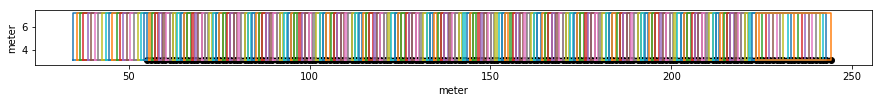

In [46]:
# plot 
D = Yre
fig, ax = plt.subplots(figsize=(15,1))

for i in range(len(D)):
    coord = D[i,:]
    coord = np.reshape(coord,(-1,2)).tolist()
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #lon, lat as x, y
    plt.plot(xs,ys)

plt.scatter(D[:,2],D[:,3],color='black')
#     plt.scatter(D[:,0],D[:,1],color='blue') # bbr
# plt.scatter(D[:,4],D[:,5],color='red') # fbl
ax = plt.gca()
plt.xlabel('meter')
plt.ylabel('meter')
ax.format_coord = lambda x,y: '%.6f, %.6f' % (x,y)
plt.show() 

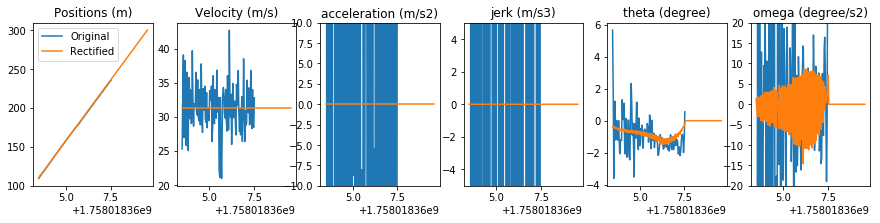

In [44]:
import utils
importlib.reload(utils)
# cx = (Y1[:,0]+Y1[:,6])/2
# cy = (Y1[:,1]+Y1[:,7])/2

fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(1, 6, figsize=(15,3))

ax1.plot(timestamps[notNan], Y1[:,0], label='Original')
ax1.plot(timestamps, Yre[:,0] , label='Rectified')
ax1.legend()
ax1.set_title('Positions (m)')
    
_,_,v1 = utils.calc_vel(Y1, timestamps[notNan])
# _,_,vre = utils.calc_vel(Yre,timestamps)
# v1 = np.diff(Y1[:,0], append=Y1[-1,0])
# vre = np.diff(Yre[:,0], append=Yre[-1,0])
ax2.plot(timestamps[notNan], v1, label='Original velocity')
ax2.plot(timestamps, v , label='Rectified velocity')
ax2.set_title('Velocity (m/s)')

a1 = utils.calc_accel(Y1[:,0], timestamps[notNan])
# are = utils.calc_accel(Yre[:,0],timestamps)
# a1 = np.diff(v1, append=v1[-1])
# are = np.diff(vre, append=vre[-1])
ax3.plot(timestamps[notNan], a1, label='Original accel')
ax3.plot(timestamps, a , label='Rectified accel')
ax3.set_title('acceleration (m/s2)')
ax3.set_ylim([-10,10])

# j1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
j1 = np.gradient(a1,timestamps[notNan])
jre = np.gradient(a, timestamps)
ax4.plot(timestamps[notNan], j1)
ax4.plot(timestamps, jre)
ax4.set_title('jerk (m/s3)')
ax4.set_ylim([-5,5])

theta1 = utils.calc_theta(Y1, timestamps[notNan])
# thetare = utils.calc_theta(Yre,timestamps)
ax5.plot(timestamps[notNan], np.degrees(theta1))
ax5.plot(timestamps, np.degrees(theta))
ax5.set_title('theta (degree)')

thetaddot1 = np.gradient(theta1,timestamps[notNan])
# thetaddotre = np.gradient(np.gradient(thetare)/dt)/dt
# theta1 = np.diff(a1, append=a1[-1])
# jre = np.diff(are, append=are[-1])
ax6.plot(timestamps[notNan], np.degrees(thetaddot1))
ax6.plot(timestamps, np.degrees(omega))
ax6.set_title('omega (degree/s2)')
ax6.set_ylim([-20,20])
plt.show()

In [266]:
# second problem: regularize jerk and omega
import utils_optimization as opt
importlib.reload(opt)
res = minimize(opt.obj2, theta0, (Yre, x,y,v,a,theta,w,l,N,dt,100,lam4,lam5), method = 'L-BFGS-B',
                bounds=[(-np.pi/8,np.pi/8) for i in range(N)], options={'disp': False,'maxiter':100000})#
Yrere, x,y,omega,theta = opt.unpack2(res,N,theta,dt,x,y,v,w,l)

[83.46725521  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

In [141]:
a=np.ones((4,4))
LA.norm(a)

4.0

In [190]:

AB = np.array([A,B])
lats = AB[:,0]
lngs = AB[:,1]
utils.draw_map_box(Y1gps[20:40],Y1gps[0,0],Y1gps[0,1], 30, lats, lngs)


###############################

 Beginning Key Insertion ...

Key Insertion Completed!!


In [274]:
a = np.vstack([np.arange(6),np.arange(6)+6])
print(a)
a = a.astype("float")
a[0,:]=np.nan
a

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]]


array([[nan, nan, nan, nan, nan, nan],
       [ 6.,  7.,  8.,  9., 10., 11.]])

In [7]:
# least squares formulation just about the same run time and results
# try calculating the gradient of objective function
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
# try having simplified decision variables and no constraints


start = time.time()


p_dim = 2  # lp norm
p = 1

dt = np.gradient(timestamps)
lam1 = 1
lam2 = 0 # regularize acceleration 100
lam3 = 10 # regularize jerk
lam4 = 100 # regularize on thetaddot
lam5 = 100
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function
        X = [cx, cy, theta, w, l]^T
    """    
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]
    w = X[3*N]
    l = X[3*N+1]
    
    # compute positions
    xa = cx + w/2*sin(theta)
    ya = cy - w/2*cos(theta)
    xb = xa + l*cos(theta)
    yb = ya + l*sin(theta)
    xc = xb - w*sin(theta)
    yc = yb + w*cos(theta)
    xd = xa - w*sin(theta)
    yd = ya + w*cos(theta)
    Yre = np.stack([xa,ya,xb,yb,xc,yc,xd,yd],axis=-1) 
    
    # min perturbation
    c1 = lam1*np.sum((Y1-Yre)**2)
    
#     # jerk regularization
#     v = np.gradient(cx,timestamps)/cos(theta)
#     a = np.gradient(v,timestamps)
#     j = np.gradient(a,timestamps)
#     c3 = lam3 * np.sum(j**2)

#     # theta ddot regularization
#     thetaddot = np.gradient(np.gradient(theta)/dt)/dt
#     c4 = lam4 * np.sum(thetaddot**2)
# #     print(c1,c3,c4)

#     # pfaffian constraint
#     vx = np.gradient(cx)/dt
#     vy = np.gradient(cy)/dt
#     c5 = lam5*np.sum((-vx*sin(theta)+vy*cos(theta))**2)
#     print(c1,c3,c4,c5)
    return c1 

def const5(X):
    # Pfaffian constraint
    cx = X[:N]
    cy = X[N:2*N]
    theta = X[2*N:3*N]

    vx = np.gradient(cx)/dt
    vy = np.gradient(cy)/dt
    return -vx*sin(theta)+vy*cos(theta)
    
#     return np.sum(c5**2)
nlc = ({"type": "eq", "fun": const5})
# initial values
cx0 = (Y1[:,0]+Y1[:,6])/2
cy0 = (Y1[:,1]+Y1[:,7])/2
w0 = 1
l0 = 4
theta0 = np.zeros((N))
X0 = np.concatenate((cx0.T, cy0.T, theta0, [w0,l0]), axis=0)
bnds = [(0,np.inf) for i in range(0,2*N)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]+[(1,4),(2,50)]
list1, list2 = zip(*bnds)
bnd_list = (list(list1),list(list2))

# Constraints definition (only for COBYLA, SLSQP and trust-constr)
res = minimize(obj, X0, method = 'L-BFGS-B',
                bounds=bnds, options={'disp': False,'maxiter':100000})#
# BFGS: fast,ok
# L-BFGS-B: really fast, ok results
# CG: slow, ok
# COBLYA: fast but results no good
# SLSQP and fmin_slsqp: inequality cosntraints incompatible
# res = fmin_slsqp(obj, X0, # inequality constraint not compatible
#                 bounds=bnds, disp= True, iter=1000)
# res = least_squares(obj, X0, # super slow
#                 bounds=bnd_list, verbose = 2)
# res = shgo(obj,bounds=bnds)
end = time.time()
print(end - start)
# extract results
cx = res.x[:N]
cy = res.x[N:2*N]
theta = res.x[2*N:3*N]
w = res.x[3*N]
l = res.x[3*N+1]

Yre = utils.calc_positions(cx,cy,theta,w,l)
print(w,l)

0.3485264778137207
1.3014620637148426 4.276270081179986


In [76]:
# optimize on the road plane
# a formulation that accounts for heading change (for lane changing)
import time
start = time.time()
from scipy.optimize import minimize,NonlinearConstraint,leastsq,fmin_slsqp
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1
lam1 = 1000
lam2 = 100 # regularize acceleration
lam3 = 2 # regularize jerk
lam4 = 10 # regularize on thetaddot
N = len(Y1)
global lam1, lam2, lam3, lam4, dt, Y1, timestamps, N

def obj(X):
    """The cost function"""    
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]

    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
    
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2
    
    # min perturbation
    c1 = lam1*LA.norm(Y1-Yre,2)
    
    # acceleration regularization
    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    v = np.sqrt(vx**2+vy**2)
    
    a = np.gradient(v)/dt
    c2 = lam2 * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam3 * LA.norm(j,2)

    # theta ddot regularization
    thetaddot = np.gradient(np.gradient(theta)/dt)/dt
    c4 = lam4 * LA.norm(thetaddot,2)
#     print(c1,c2,c3,c4)
    return c1 + c2 + c3 +c4

def const4(X):
    # rectangle shape constraint using theta
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    sos = np.sum((cx + w/2*sin(theta) - Yre[:,0])**2)\
        + np.sum((cy - w/2*cos(theta) - Yre[:,1])**2)\
        + np.sum((Yre[:,0]+l*cos(theta)-Yre[:,2])**2)\
        + np.sum((Yre[:,1]+l*sin(theta)-Yre[:,3])**2)\
        + np.sum((Yre[:,2]-w*sin(theta)-Yre[:,4])**2)\
        + np.sum((Yre[:,3]+w*cos(theta)-Yre[:,5])**2)\
        + np.sum((Yre[:,0]-w*sin(theta)-Yre[:,6])**2)\
        + np.sum((Yre[:,1]+w*cos(theta)-Yre[:,7])**2)
    return sos
#     return 0.0001-sos

def const5(X):
    # Pfaffian constraint
    X_data = X[:8*N]
    w = X[8*N]
    l = X[8*N+1]
    Yre = X_data.reshape(N, -1)
    Yre = np.reshape(X_data,(-1,N)).T
    theta = X[8*N+2:]
#     theta = utils.calc_theta(Yre, timestamps)
    # calculate cs, cy
    cx = (Yre[:,0]+Yre[:,6])/2
    cy = (Yre[:,1]+Yre[:,7])/2

    dx = np.gradient(cx)
    vx = dx/dt
    dy = np.gradient(cy)
    vy = dy/dt
    c5 = -vx*sin(theta)+vy*cos(theta)
    return np.sum(c5**2)
#     return 0.001-np.sum(c5**2)

nlc = ({"type": "eq", "fun": const4},
      {"type": "eq", "fun": const5})

Y1f = Y1.flatten('F')
theta0 = np.zeros((N))
X0 = np.concatenate((Y1f, [1.1, 3],theta0), axis=0)
bnds = [(0,np.inf) for i in range(0,8*N)]+[(1,4),(2,50)]+[(-np.pi/8,np.pi/8) for i in range(len(theta0))]

res = minimize(obj, X0, method = 'SLSQP',
                constraints=nlc,
                bounds=bnds, options={'disp': True, 'maxiter':1000})

end = time.time()
print(end - start)

X_data = res.x[:8*N]
w = res.x[8*N]
l = res.x[8*N+1]
theta = res.x[8*N+2:]
#     theta = X[8*N+2:]
Yre = np.reshape(X_data,(-1,N)).T
# theta = utils.calc_theta(Yre, timestamps)
print(w,l)


TypeError: 'dict' object is not callable

In [84]:
# ver1: slow but accurate
# optimize on the road plane
# returns sigular matrix (constraints not continuous) if using equality constraints
import time

start = time.time()
from scipy.optimize import minimize,NonlinearConstraint
import numpy.linalg as LA
p_dim = 2  # lp norm
p = 1


lam = 0.001 # regularize acceleration
lam2 = 0.0001 # regularize jerk
global lam, lam2, dt, Y1, timestamps

def obj(X):
    """The cost function"""   
#     global Yre, w, l
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
#     
    # min perturbation
    c1 = LA.norm(Y1-Yre,2)

    # acceleration regularization
    dx = np.gradient(Yre[:,0])
    v = dx/dt
    a = np.gradient(v)/dt
    c2 = lam * LA.norm(a,2)
    
    # jerk regularization
    j = np.gradient(a)/dt
    c3 = lam2 * LA.norm(j,2)
    return c1 + c2 + c3

def const1(X):
    # l, l, w, w, squared
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2)
#     return (Yre[:,[2,4,3,1]]-Yre[:,[0,6,5,7]]-np.array([l,l,w,w]))**2
          
def const2(X):
    # rectangle shape constraint
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.0001-np.sum((Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]])**2)
#     return (Yre[:,[1,7,2,0]]-Yre[:,[3,5,4,6]]).flatten('F')
                  
def const3(X):
    # follow straight lines movement and widthes are parallel to lanes
    X_data = X[:-2]
    w = X[-2]
    l = X[-1]
    Yre = X_data.reshape(len(Y1), -1)
    Yre = np.reshape(X_data,(-1,len(Y1))).T
    return 0.1 - np.std(Yre[:,3]) - np.std(Yre[:,1]) - np.std(Yre[:,5]) - np.std(Yre[:,7])
#     return np.std(Yre[:,3]) + np.std(Yre[:,1]) + np.std(Yre[:,5]) + np.std(Yre[:,7])


nlc = ({"type": "ineq", "fun": const1},
       {"type": "ineq", "fun": const2},
       {"type": "ineq", "fun": const3})
Y1f = Y1.flatten('F')
X0 = np.append(Y1f,[2.2, 4])
bnds = [(0,np.inf) for i in range(0,len(X0)-2)]+[(1,3),(2,np.inf)]

res = minimize(obj, X0, method='SLSQP', 
               constraints=nlc,
               bounds=bnds, options={'disp': True, 'maxiter':1000})
end = time.time()
print(end - start)

X_data = res.x[:-2]
w = res.x[-2]
l = res.x[-1]
Yre = np.reshape(X_data,(-1,len(Y1))).T

print(w,l)


Iteration limit exceeded    (Exit mode 9)
            Current function value: 13.814819920458618
            Iterations: 1001
            Function evaluations: 290232
            Gradient evaluations: 998
104.13162207603455
1.000000000000086 4.313711616444018


In [22]:
lat1, lon1 = A
lat2, lon2 = B
pt = 'bbl'
pt_lats = np.array(Y1[[pt+'lat']])
pt_lons = np.array(Y1[[pt+'lon']])
toA = utils.haversine_distance(lat1, lon1, pt_lats, pt_lons)
toAB = utils.pt_to_line_dist_gps(lat1, lon1, lat2, lon2, pt_lats, pt_lons)
x = np.sqrt(toA**2-toAB**2)

In [ ]:
# histogram of distance _y
n, bins, patches = plt.hist(x=Yre[:,2]-Yre[:,0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [ ]:
# one-step ahead prediction from Y2 using vx and vy
def one_step_predict(Y, vx, vy, fps):
    Y2pred = Y.copy()
    Y2pred[:,[0,2,4,6]] = Y[:,[0,2,4,6]] + vx*1/fps
    Y2pred[:,[1,3,5,7]] = Y[:,[1,3,5,7]] + vy*1/fps
    return Y2pred

In [ ]:
# in lat/long per second
vx = (Y1.loc[Y1.index[-1]].bbrlat - Y1.loc[Y1.index[0]].bbrlat)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
vy = (Y1.loc[Y1.index[-1]].bbrlon - Y1.loc[Y1.index[0]].bbrlon)/(Y1.loc[Y1.index[-1]].Timestamp - Y1.loc[Y1.index[0]].Timestamp)
print(vx, vy)
Y3pred = one_step_predict(Y3, vx, vy, fps)